# Installation and Setup

In [3]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz

--2021-11-25 17:44:08--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b0.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156407520 (149M) [application/octet-stream]
Saving to: ‘noisy_student_efficientnet-b0.tar.gz’

noisy_student_effic 100%[===================>] 149.16M   121MB/s    in 1.2s    

2021-11-25 17:44:10 (121 MB/s) - ‘noisy_student_efficientnet-b0.tar.gz’ saved [156407520/156407520]



In [4]:
!tar -xf noisy_student_efficientnet-b0.tar.gz

In [5]:
!python efficientnet_weight_update_util.py --model b0 --notop --ckpt noisy_student_efficientnet-b0/model.ckpt --o efficientnetb0_notop.h5

2021-11-25 17:44:44.899072: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
16719872/16705208 [==============================] - 0s 0us/step
check variables match in each block
blocks_0 and block1a match.
blocks_1 and block2a match.
blocks_2 and block2b match.
blocks_3 and block3a match.
blocks_4 and block3b match.
blocks_5 and block4a match.
blocks_6 and block4b match.
blocks_7 and block4c match.
blocks_8 and block5a match.
blocks_9 and block5b match.
blocks_10 and block5c match.
blocks_11 and block6a match.
blocks_12 and block6b match.
blocks_13 and block6c match.
blocks_14 and block6d match.
blocks_15 and block7a match.
skipping variable normalization/mean:0: normalization is a layerin keras implementation, but preprocessing in TF implementation.
skipping variable normalization/variance:0: normalization is a layerin keras implementation, but p

In [6]:
!pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


# Data Preparation

In [30]:
import shutil
import os
import pandas as pd

shutil.rmtree('data')

In [31]:
os.mkdir('data')

In [ ]:
!unrar x imgs.rar data

In [37]:
from os import listdir
from os.path import isfile, join

data_path = 'data/'
json_files = json_files = [pos_json for pos_json in listdir(data_path) if pos_json.endswith('.json')]

In [38]:
import json
df = pd.DataFrame(columns=['image_location', 'point1', 'point2'])

for json_file in json_files:
  with open(data_path+json_file) as jf:
      d = json.load(jf)
      arr = list(eval(d['eye_details']['look_vec']))
      df = df.append({'image_location': data_path+json_file.split('.')[0]+'.jpg', 'point1': arr[0], 'point2': arr[1]}, ignore_index=True)

In [39]:
df

,image_location,point1,point2
0,data/598.jpg,-0.7805,0.0377
1,data/958.jpg,-0.6229,0.0473
2,data/375.jpg,0.1197,0.0998
3,data/499.jpg,0.0287,0.5053
4,data/84.jpg,0.7551,-0.1027
...,...,...,...
1153,data/1035.jpg,0.1715,-0.3533
1154,data/453.jpg,-0.3691,-0.6516
1155,data/143.jpg,0.2598,-0.4299
1156,data/254.jpg,-0.6817,0.1830


In [128]:
df.loc[df['image_location'] == 'data/1.jpg']

,image_location,point1,point2
531,data/1.jpg,0.2857,0.1601


# Main

In [40]:
# General libraries
import pandas as pd  #For working with dataframes
import numpy as np   #For working with image arrays
import cv2          #For transforming image
import matplotlib.pyplot as plt  #For representation
#For model building
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, models, utils
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader 
from PIL import Image
from torch.utils.data import random_split
from torch.nn import functional as F
from skimage import io, transform
from torch.optim import lr_scheduler
from skimage.transform import AffineTransform, warp
import numpy as np

In [41]:
class MyData(Dataset):
    def __init__(self, df, transforms=None):      
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_location = self.df['image_location'].iloc[idx]
        img = Image.open(image_location).convert("RGB")

        label1 = self.df['point1'].iloc[idx]
        label2 = self.df['point2'].iloc[idx]
        label1 = torch.as_tensor(label1, dtype=torch.float32)
        label2 = torch.as_tensor(label2, dtype=torch.float32)
        target = {}
        target['point1'] = label1
        target['point2'] = label2
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label1, label2

In [42]:
transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

In [43]:
dataset = MyData(df, transforms=transforms)

In [44]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(1043, 115)

In [45]:
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [185]:
for sample in train_dl:
  imgs, label1, label2 = sample
  # print(imgs)
  print(label1)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([-0.0203,  0.1610, -0.1573, -0.3035,  0.4969,  0.0796, -0.7217, -0.0651])


In [59]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels1, labels2 = batch 
        outs = self(images)
        # print("1", labels1)
        # print("2", outs['label1'])
        loss1 = F.mse_loss(outs['label1'], labels1)
        loss2 = F.mse_loss(outs['label2'], labels2)
        loss = loss1 + loss2
        return loss
    
    def validation_step(self, batch):
        images, labels1, labels2 = batch 
        outs = self(images)
        loss1 = F.mse_loss(outs['label1'], labels1)
        loss2 = F.mse_loss(outs['label2'], labels2)
        loss = loss1 + loss2
        # acc = accuracy(outs, labels1, labels2)           # Calculate accuracy
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))
        
# def accuracy(outs, labels1, labels2):
#     _, preds = torch.max(outputs, dim=1)
#     return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [60]:
class CNN1(ImageClassificationBase):
    def __init__(self):
        super(CNN1, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
        self.fc1 = nn.Linear(1280, 1)  #For age class
        self.fc2 = nn.Linear(1280, 1)    #For gender class
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        label1 = self.fc1(x)
        label1 = torch.reshape(label1, (1, -1))
        label2 = self.fc2(x)
        label2 = torch.reshape(label2, (1, -1))
        return {'label1': label1[0], 'label2': label2[0]}

In [48]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [49]:
device = get_default_device()
device

device(type='cuda')

In [50]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [51]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [134]:
l = torch.nn.MSELoss([1, 2, 3], [1, 2, 4])
l

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


MSELoss()

In [61]:
model = to_device(CNN1(), device)

In [193]:
for sample in train_dl:
  imgs, label1, label2 = sample
  outs = model(imgs)
  print(outs['label1'])
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([-0.3687, -0.4188,  0.1919, -0.2622, -0.0662,  0.0890, -0.1475,  0.0291],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [53]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [62]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.2531, val_loss: 0.1302
Epoch [1], train_loss: 0.0867, val_loss: 0.0510
Epoch [2], train_loss: 0.0449, val_loss: 0.0240
Epoch [3], train_loss: 0.0237, val_loss: 0.0127
Epoch [4], train_loss: 0.0136, val_loss: 0.0082


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [64]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

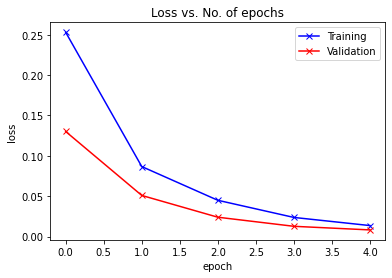

In [65]:
plot_losses(history)

In [160]:
import cv2
from google.colab.patches import cv2_imshow

def draw(path, points):
  img = cv2.imread(path)
  c_x, c_y = get_eye_pupil(path)
  c_x, c_y = c_x*2, c_y*2
  print(c_x, c_y)
  x, y = points[0], points[1]
  cv2.arrowedLine(img, (c_x, c_y), (c_x+x*80, c_y+y*80), (0, 255, 0), 2)
  # cv2.circle(img, (c_x, c_y), 0, color=(0, 0, 255))

  cv2_imshow(img)

In [145]:
test_df = df[:5]
test_ds = MyData(test_df, transforms)
test_dl = DataLoader(test_ds, batch_size=8, num_workers=4)
test_dl = DeviceDataLoader(test_dl, device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [130]:
test_df

,image_location,point1,point2
530,data/364.jpg,-0.3352,-0.1653
531,data/1.jpg,0.2857,0.1601
532,data/117.jpg,0.7186,0.2866
533,data/1019.jpg,0.6031,-0.3718


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'label1': tensor([-0.7984, -0.6988,  0.1184, -0.0113,  0.8291], device='cuda:0',
       grad_fn=<SelectBackward0>), 'label2': tensor([ 3.5514e-02,  4.3105e-02,  6.5693e-05,  5.2467e-01, -1.6232e-01],
       device='cuda:0', grad_fn=<SelectBackward0>)}
(192, 256, 3) 2 2 0.0
Ckecking...
(192, 256, 3) 2 2 0.5
Ckecking...
(192, 256, 3) 15 21 200.0
Ckecking...
218 188


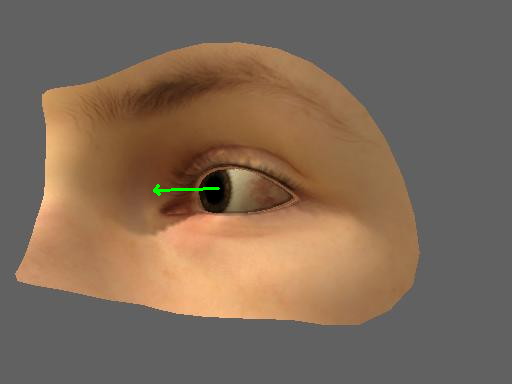

In [161]:
for batch in test_dl:
  imgs, label1, label2 = batch
  outs = model(imgs)
  print(outs)
  inx = 0
  draw(test_df['image_location'][inx], [outs['label1'][inx], outs['label2'][inx]])

In [113]:
import cv2
import math
import numpy as np

def get_eye_pupil(img_file):
    img = cv2.imread(img_file)
    scaling_factor = 0.5


    img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
    # cv2.imshow('Input', img)
    gray = cv2.cvtColor(~img, cv2.COLOR_BGR2GRAY)

    ret, thresh_gray = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    x, y, radius = None, None, None
    for contour in contours:
        area = cv2.contourArea(contour)
        rect = cv2.boundingRect(contour)
        x, y, width, height = rect
        radius = 0.25 * (width + height)
        print(img.shape, width, height, area)

        area_condition = (100 <= area <= 225)
        symmetry_condition = (abs(1 - float(width)/float(height)) <= 0.2)
        fill_condition = (abs(1 - (area / (math.pi * math.pow(radius, 2.0)))) <= 0.3)

        print("Ckecking...")
        if area_condition and symmetry_condition and fill_condition:
            print("HERE")
            print(int(x + radius), int(y + radius))
            cv2.circle(img, (int(x + radius), int(y + radius)), int(radius), color=(255, 0, 0))
            cv2.circle(img, (int(x + radius), int(y + radius)), 0, color=(0, 0, 255))

    return (int(x + radius), int(y + radius))
    # cv2.namedWindow('Pupil Detector', cv2.WINDOW_KEEPRATIO)
    # cv2.imshow('Pupil Detector', img)

    # c = cv2.waitKey(0)
    # cv2.destroyAllWindows()